# Drive access
* Mount Drive
* Change Directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My\ Drive/banglaOCR/

/content/gdrive/My Drive/banglaOCR


# Initialize TPU

In [4]:
import tensorflow as tf
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

print("Number of accelerators: ", strategy.num_replicas_in_sync)
print("BATCH_SIZE: ", str(BATCH_SIZE))

INFO:tensorflow:Initializing the TPU system: grpc://10.27.227.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.227.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8
BATCH_SIZE:  128


# Setup Segmentation Model

In [5]:
!pip install segmentation_models -q

     |████████████████████████████████| 51kB 4.4MB/s 


In [6]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


# Data Access
* Train Images:160672 
* Eval Images:40168

In [7]:
IMG_DIM    =   128# @param
NB_CHANNEL =    1# @param
NB_TRAIN   =  160672 # @param
NB_TEST    =  40168 # @param
EPOCHS     =  250 # @param
BUFFER_SIZE = 2048  # @param

TOTAL_DATA =  NB_TRAIN+NB_TEST 
STEPS_PER_EPOCH = TOTAL_DATA//BATCH_SIZE
EVAL_STEPS      = NB_TEST//BATCH_SIZE
print(STEPS_PER_EPOCH)

1569


In [8]:
GCS_PATH    =    "gs://kds-5e4d2e067129ad6a82a4a2870edeef3bd31cea120cdae318a57f8102"# @param 
TF_IDEN     =    "grapheme" # @param 
DATA_FOLDER =    "tfrecords"# @param
GCS_PATH    =    f'{GCS_PATH}/{TF_IDEN}/{TF_IDEN}/{DATA_FOLDER}'
print(GCS_PATH)

gs://kds-5e4d2e067129ad6a82a4a2870edeef3bd31cea120cdae318a57f8102/grapheme/grapheme/tfrecords


In [9]:
def data_input_fn(mode): 
    '''
      This Function generates data from gcs
    '''
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string),
                    'target' : tf.io.FixedLenFeature((),tf.string)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))
        


        target_raw=parsed_example['target']
        target=tf.image.decode_png(target_raw,channels=NB_CHANNEL)
        target=tf.cast(target,tf.float32)/255.0
        target=tf.reshape(target,(IMG_DIM,IMG_DIM,NB_CHANNEL))
        return image,target

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

### Data Check

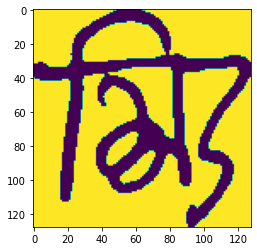

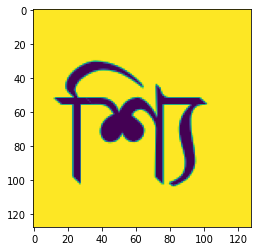

Image Batch Shape: (128, 128, 128, 1)
Target Batch Shape: (128, 128, 128, 1)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")


for x,y in eval_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    data=np.squeeze(y[0])
    plt.imshow(data)
    plt.show()
    
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    

# Model Definition

In [11]:
backbone= "efficientnetb7"# @param
def ssim(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


WEIGHT_PATH=os.path.join(os.getcwd(),'modifier.h5')
with strategy.scope():   
  model = sm.Unet(backbone,
                  input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL), 
                  classes=NB_CHANNEL,
                  encoder_weights=None)
  model.compile(optimizer = "Adam",
                loss = tf.keras.losses.mean_squared_error,
                metrics=[ssim])


# Callbacks

In [12]:

# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,
                               verbose =1,
                               min_lr=0.1e-5)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  monitor='val_loss', 
                                                  mode = 'min', 
                                                  save_best_only=True, 
                                                  verbose=1, 
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, 
                               verbose=1, 
                               mode = 'auto') 

callbacks = [mode_autosave, lr_reducer,early_stopping ]

# Training

In [13]:

history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
1569/1569 [==============================] - 524s 233ms/step - loss: 0.0540 - ssim: 0.6630 - val_loss: 0.0371 - val_ssim: 0.7799

Epoch 00001: val_loss improved from inf to 0.03709, saving model to /content/gdrive/My Drive/banglaOCR/modifier.h5
Epoch 2/250
1569/1569 [==============================] - 351s 224ms/step - loss: 0.0347 - ssim: 0.7825 - val_loss: 0.0248 - val_ssim: 0.8424

Epoch 00002: val_loss improved from 0.03709 to 0.02482, saving model to /content/gdrive/My Drive/banglaOCR/modifier.h5
Epoch 3/250
1569/1569 [==============================] - 352s 224ms/step - loss: 0.0239 - ssim: 0.8426 - val_loss: 0.0169 - val_ssim: 0.8878

Epoch 00003: val_loss improved from 0.02482 to 0.01690, saving model to /content/gdrive/My Drive/banglaOCR/modifier.h5
Epoch 4/250
1569/1569 [==============================] - 352s 224ms/step - loss: 0.0167 - ssim: 0.8869 - val_loss: 0.0119 - val_ssim: 0.9221

Epoch 00004: val_loss improved from 0.01690 to 0.01194, saving model to /conten

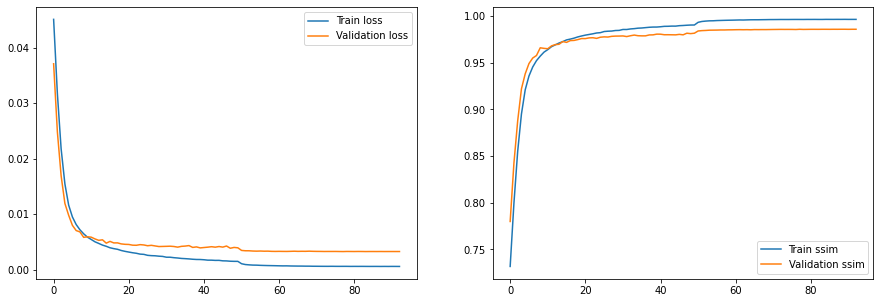

In [14]:
def plot_history(history):
  """
  Plots model training history 
  """
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
  ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
  ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["ssim"], label="Train ssim")
  ax_acc.plot(history.epoch, history.history["val_ssim"], label="Validation ssim")
  ax_acc.legend()
  plt.show()
# show history
plot_history(history)